In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# sci-kit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix

# sci-kit Random Forest and Extra Trees
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#lightGBM
import lightgbm as lgb

#SHAP
import shap
from shap import summary_plot, force_plot, dependence_plot

# Here I categorise qualities into 3 bins

In [2]:
df = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')
X = df[["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]]

# split the qualities into 3 bins: low: <6, Medium: 6, High: >6
def categorize_quality(value):
    if value < 6:
        return 'Low'
    elif value == 6:
        return 'Medium'
    else:
        return 'High'
df['quality_bin'] = df['quality'].apply(categorize_quality)
y = df["quality_bin"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# I chose default parameters, and played around with learning rate and max bin to obtain a higher accuracy

In [3]:
# Define parameters for LightGBM
params = {
    'objective': 'multiclass',       # Multiclass classification
    'num_class': len(np.unique(y)),  # Number of classes
    'metric': 'multi_logloss',       # Evaluation metric
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Trees
    'num_leaves': 31,                # Number of leaves
    'learning_rate': 0.05,           # Learning rate
    'feature_fraction': 0.9,         # Fraction of features to use
    'max_bin': 512,                  # Maximum number of bins
    'verbose': -1,                   # Suppress LightGBM logs
}

# Train LightGBM Classifier
gbm = lgb.LGBMClassifier(**params, n_estimators=150, random_state=11)
gbm.fit(X_train, y_train)

# Generate predictions
y_pred = gbm.predict(X_test)


# Create results table
results = []
unique_labels = sorted(set(y_test))  # Unique actual labels

for label in unique_labels:
    # Get indices of samples with the current actual label
    indices = [i for i, actual in enumerate(y_test) if actual == label]

    # Extract corresponding predictions
    predictions = [y_pred[i] for i in indices]

    # Count occurrences of each predicted label
    prediction_counts = Counter(predictions)

    # Calculate correct predictions and percentage
    correct_predictions = prediction_counts.get(label, 0)  # Get count of correct predictions
    total_actual = len(indices)
    correct_percentage = (correct_predictions / total_actual) * 100 if total_actual > 0 else 0

    # Add row to results
    results.append({
        "Actual Label": label,
        "Count of Actual Samples": total_actual,
        "Predicted Labels": list(prediction_counts.keys()),
        "Counts of Predictions": list(prediction_counts.values()),
        "Correct Prediction %": f"{correct_percentage:.2f}%"  # Format as a percentage
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

  Actual Label  Count of Actual Samples     Predicted Labels  \
0         High                       51  [High, Medium, Low]   
1          Low                      150  [High, Low, Medium]   
2       Medium                      119  [Medium, Low, High]   

  Counts of Predictions Correct Prediction %  
0           [32, 13, 6]               62.75%  
1          [2, 115, 33]               76.67%  
2           [85, 25, 9]               71.43%  


# We build a confusion matrix and print the classification report to better interpret the results

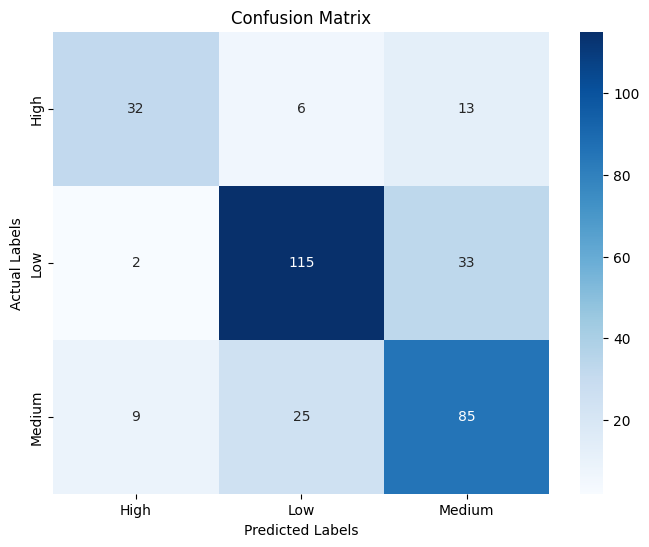

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

        High       0.74      0.63      0.68        51
         Low       0.79      0.77      0.78       150
      Medium       0.65      0.71      0.68       119

    accuracy                           0.73       320
   macro avg       0.73      0.70      0.71       320
weighted avg       0.73      0.72      0.73       320



In [4]:
cm = confusion_matrix(y_test, y_pred)
 
# Visualizing the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['High', 'Low', 'Medium'], yticklabels=['High', 'Low', 'Medium'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Next, the global SHAP values are generated

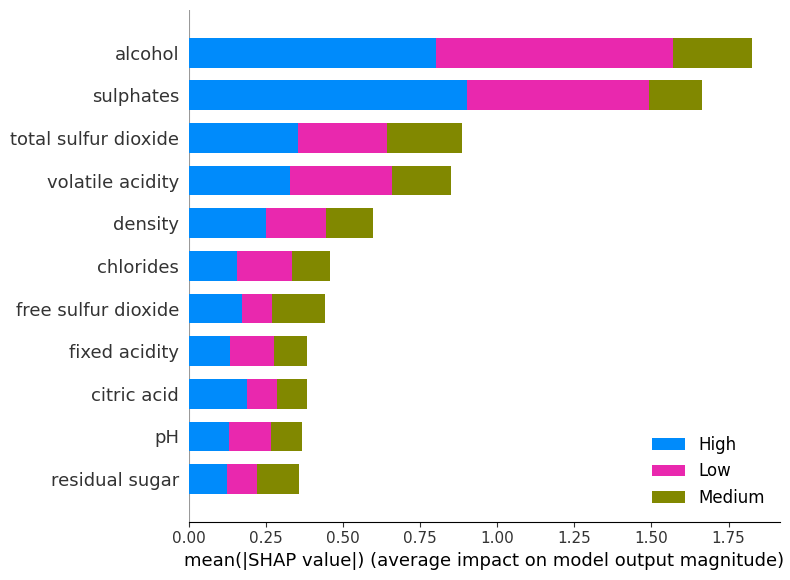

In [5]:
class_names = np.unique(y_train)

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, class_names=class_names)

In [6]:
shap.initjs()

sample_number = 11
print("Features of sample")
print(X_test.iloc[sample_number])
print("Actual Quality")
print(y_test.iloc[sample_number])
print("Predicted Quality")
print(y_pred[sample_number])

Features of sample
fixed acidity            7.50000
volatile acidity         0.52000
citric acid              0.40000
residual sugar           2.20000
chlorides                0.06000
free sulfur dioxide     12.00000
total sulfur dioxide    20.00000
density                  0.99474
pH                       3.26000
sulphates                0.64000
alcohol                 11.80000
Name: 1575, dtype: float64
Actual Quality
Medium
Predicted Quality
Medium


# Three random samples are chosen in order to find the local shap values

In [7]:
shap.plots.force(explainer.expected_value[0], shap_values[0][sample_number],X_test.iloc[sample_number])  # Single instance

In [8]:
sample_number = 42
print(X_test.iloc[sample_number])
print(y_test.iloc[sample_number])
print(y_pred[sample_number])
shap.plots.force(explainer.expected_value[0], shap_values[0][sample_number],X_test.iloc[sample_number])  # Single instance

fixed acidity            8.9000
volatile acidity         0.8750
citric acid              0.1300
residual sugar           3.4500
chlorides                0.0880
free sulfur dioxide      4.0000
total sulfur dioxide    14.0000
density                  0.9994
pH                       3.4400
sulphates                0.5200
alcohol                 11.5000
Name: 731, dtype: float64
Low
Low


In [9]:
sample_number = 100
print(X_test.iloc[sample_number])
print(y_test.iloc[sample_number])
print(y_pred[sample_number])
shap.plots.force(explainer.expected_value[0], shap_values[0][sample_number],X_test.iloc[sample_number])  # Single instance

fixed acidity             7.900
volatile acidity          0.530
citric acid               0.240
residual sugar            2.000
chlorides                 0.072
free sulfur dioxide      15.000
total sulfur dioxide    105.000
density                   0.996
pH                        3.270
sulphates                 0.540
alcohol                   9.400
Name: 311, dtype: float64
Medium
Low
